In [ ]:
!pip install h5py
!pip install  unidecode


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 8.4 MB/s eta 0:00:00


In [ ]:
!pip install  tensorflow



In [ ]:
!pip install deep-translator


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from pandas import read_excel
import numpy as np
import re
from re import sub
import multiprocessing
from unidecode import unidecode
import os
from time import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    LSTM, Dense, Dropout, Activation, Embedding, Flatten,
    Bidirectional, MaxPooling2D, Conv1D, MaxPooling1D
)
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import h5py
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from deep_translator import GoogleTranslator

# Load dataset
df = pd.read_csv("/content/combined_data.csv", usecols=["Text", "Fraud level"])

# Remove rows where 'Fraud level' is NaN or not in [0, 1]
df = df[df['Fraud level'].isin([0, 1])]

# Split dataset (80% training, 20% test)
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["Fraud level"])
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42, stratify=train_val_df["Fraud level"])

# Function for back translation (Bangla → English → Bangla)
def back_translate(text, src_lang="bn", mid_lang="en"):
    try:
        translated = GoogleTranslator(source=src_lang, target=mid_lang).translate(text)
        back_translated = GoogleTranslator(source=mid_lang, target=src_lang).translate(translated)
        return back_translated
    except:
        return text  # If translation fails, return original text

# Create a new DataFrame with back-translated and concatenated text
back_translated_df = train_df.copy()
back_translated_df["Text"] = back_translated_df["Text"].apply(lambda x: x + " " + back_translate(x))

# Concatenate original training set with back-translated set
augmented_train_df = pd.concat([train_df, back_translated_df], ignore_index=True)

# Display results
print("Original Training Set Size:", len(train_df))
print("New Augmented Training Set Size:", len(augmented_train_df))  # Should be double
print("\nSample of Augmented Training Set:\n", augmented_train_df.head(10))
print("\nTest Set (Unchanged):\n", test_df.head())

# Check if 'Fraud level' values remain [0, 1] in both sets
print("\nUnique Fraud Levels in Training Set:", augmented_train_df['Fraud level'].unique())
print("Unique Fraud Levels in Test Set:", test_df['Fraud level'].unique())


Original Training Set Size: 824
New Augmented Training Set Size: 1648

Sample of Augmented Training Set:
                                                 Text  Fraud level
0          চুলকে স্বাস্থ্যোজ্জল ও আকর্ষণীয় করে তোলে।          0.0
1  ফুল বডি কেয়ার লোশন – ময়েশ্চারাইজিং ও হোয়াইট...          1.0
2                                      ত্বক মসৃণ করে          1.0
3  যাদের ঠোঁট কালো দাগ আছে ড্রাই থাকে সব সময় ও...          1.0
4        চামড়া কুচকে যাওয়া ও ঝুলে যাওয়া ভাব দুর করে।          0.0
5  ময়েশ্চরাইজ করে ধরে রাখবে পারফেক্ট অয়েল ব্যালান...          1.0
6  ক্রিম ব্যবহার করা ছাড়া ফেস ওয়াসের মাধ্যমে ফরসা...          1.0
7            ৩.#হা'ত #পা'য়ের #কা'লো #দা'গ দূ'র করবে।          1.0
8                        হার্ট অ্যাটাকের ঝুঁকি কমায়।          0.0
9                                ব্রণের ক্ষত দূর করে          0.0

Test Set (Unchanged):
                                                    Text  Fraud level
609                                    বলিরেখা দূর করে।          0.0
208   

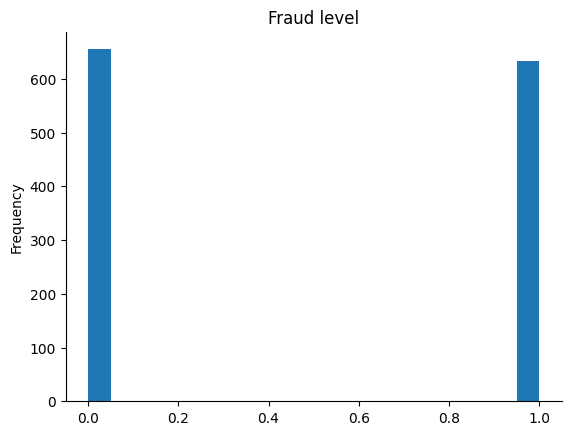

In [ ]:
# @title Fraud level

from matplotlib import pyplot as plt
df['Fraud level'].plot(kind='hist', bins=20, title='Fraud level')
plt.gca().spines[['top', 'right',]].set_visible(False)

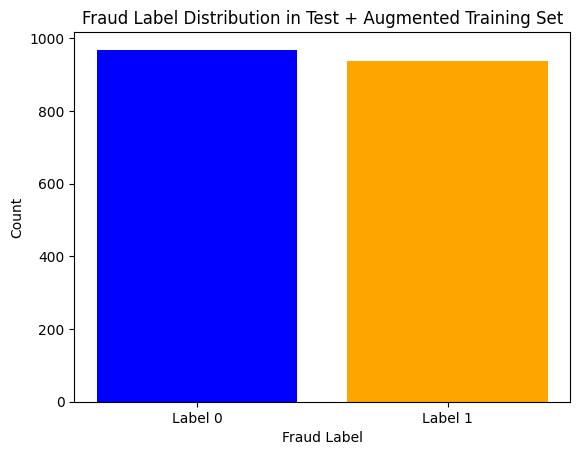

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Combine test and augmented training set for visualization
df_combined = pd.concat([test_df, augmented_train_df])

# Count fraud labels
fraud_counts = df_combined['Fraud level'].value_counts()

# Plot the counts
plt.bar(fraud_counts.index, fraud_counts.values, color=['blue', 'orange'])
plt.xticks([0, 1], labels=['Label 0', 'Label 1'])
plt.xlabel('Fraud Label')
plt.ylabel('Count')
plt.title('Fraud Label Distribution in Test + Augmented Training Set')
plt.show()


In [ ]:
display(df)
df.head()
df.describe()
df.info()


,Text,Fraud level
0,"হাত, পা,গলা এবং ঘাড় সহ পুরো শরীর ফর্সা করবে",1.0
1,ফর্সা করার জন্য ও স্কিনের গ্লো ফিরিয়ে আনবে,0.0
2,ঠোটকে করবে প্রাকৃতিক ভাবে গোলাপি মরা চামড়া দুর...,1.0
3,অতিরিক্ত ওজন কমিয়ে নিজেকে সুস্থ রাখুন,1.0
4,ব্রণের দাগ ও বয়সের ছাপ কমায় এবং ত্বক সুরক্ষিত ...,1.0
...,...,...
1285,রতরে স্কিন ধবধবে ফর্সা করবে ১০০% ও মেছতা ও ব্র...,1.0
1292,মুখ হবে ধবধবে ফ/র্সা এক কম্বতেই,1.0
1293,কোনো প্রকার পার্শ্ব পতিক্রিয়া ছাড়া দাগহীন গ্লো...,1.0
1294,১০০% অরিজিনাল এবং অথেনটিক প্রডাক্টের নিশ্চয়তা।,1.0


<class 'pandas.core.frame.DataFrame'>
Index: 1289 entries, 0 to 1295
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Text         1289 non-null   object 
 1   Fraud level  1289 non-null   float64
dtypes: float64(1), object(1)
memory usage: 30.2+ KB


In [ ]:
def text_to_word_list(text):
    text = text.split()
    return text

def replace_strings(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"
                           u"\u2000-\u206F"

                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)


    text=emoji_pattern.sub(r'', text)
    text=english_pattern.sub(r'', text)

    return text

def remove_punctuations(my_str):

    punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰⚽️✌�￰৷￰'''

    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char


    return no_punct



def joining(text):
    out=' '.join(text)
    return out

def preprocessing(text):
    out=remove_punctuations(replace_strings(text))
    return out

In [ ]:
augmented_train_df['Text'] = augmented_train_df.Text.apply(lambda x: preprocessing(str(x)))
test_df['Text'] = test_df.Text.apply(lambda x: preprocessing(str(x)))
val_df['Text'] = val_df.Text.apply(lambda x: preprocessing(str(x)))

In [ ]:
augmented_train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Ensure your DataFrames are defined somewhere
# train1 = augmented_train_df
# test1 = test_df
# val_df = your_validation_dataframe

# Replace these with your actual DataFrames if not defined yet
train1 = augmented_train_df
test1 = test_df
val_df = val_df  # Define this appropriately

# Extract sentences and labels
train_sentences = train1['Text'].astype(str).values
train_labels = train1['Fraud level'].values

test_sentences = test1['Text'].astype(str).values
test_labels = test1['Fraud level'].values

validation_sentences = val_df['Text'].astype(str).values
validation_labels = val_df['Fraud level'].values

# One-hot encode the labels
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
validation_labels = to_categorical(validation_labels)

# Print dataset information
print("Training Set Length:", len(train1))
print("Testing Set Length:", len(test1))
print("Validation Set Length:", len(val_df))
print("training_sentences shape:", train_sentences.shape)
print("testing_sentences shape:", test_sentences.shape)
print("validation_sentences shape:", validation_sentences.shape)
print("train_labels shape:", train_labels.shape)
print("test_labels shape:", test_labels.shape)
print("validation_labels shape:", validation_labels.shape)


Training Set Length: 1648
Testing Set Length: 258
Validation Set Length: 207
training_sentences shape: (1648,)
testing_sentences shape: (258,)
validation_sentences shape: (207,)
train_labels shape: (1648, 2)
test_labels shape: (258, 2)
validation_labels shape: (207, 2)


In [ ]:
print(training_sentences[79])
print(train_labels[0])

ত্বকের গঠন উন্নত করা
[1. 0.]


In [ ]:
vocab_size = 25000
embedding_dim = 300
max_length = 100
trunc_type='post'
oov_tok = "<OOV>"

In [ ]:
print(training_sentences.shape)
print(train_labels.shape)

(1648,)
(1648, 2)


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Fit on training data only
tokenizer.fit_on_texts(training_sentences)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(training_sentences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(testing_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length)

# ✅ Missing part: Validation
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length)

# Optional: Print info
print("Word index length:", len(tokenizer.word_index))
print("Train padded shape:", train_padded.shape)
print("Test padded shape:", test_padded.shape)
print("Validation padded shape:", validation_padded.shape)


Word index length: 2705
Train padded shape: (1648, 100)
Test padded shape: (258, 100)
Validation padded shape: (207, 100)


In [ ]:
print("Sentence :--> \n")
print(training_sentences[3]+"\n")
print("Sentence Tokenized and Converted into Sequence :--> \n")
print(str(sequences[3])+"\n")
print("After Padding the Sequence with padding length 100 :--> \n")
print(padded[3])

Sentence :--> 

যাদের ঠোঁট কালো দাগ আছে ড্রাই থাকে সব সময় ও ফেটে যাওয়ার প্রবলেম আছে তাদের জন্য বেস্ট

Sentence Tokenized and Converted into Sequence :--> 

[247, 1220, 495, 9, 58, 386, 229, 147, 608, 4, 927, 928, 675, 58, 128, 11, 676]

After Padding the Sequence with padding length 100 :--> 

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0  247
 1220  495    9   58  386  229  147  608    4  927  928  675   58  128
   11  676]


In [ ]:
print("Padded shape(training): "+str(padded.shape))
print("Padded shape(testing): "+str(testing_padded.shape))
print("Padded shape(validation): "+str(validation_padded.shape))

Padded shape(training): (1648, 100)
Padded shape(testing): (258, 100)
Padded shape(validation): (207, 100)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Bidirectional, LSTM, GRU, Dropout, Dense, GlobalAveragePooling1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(Conv1D(256, kernel_size=3, activation = "relu"))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.20))
model.add(Conv1D(512, kernel_size=3, activation = "relu"))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.20))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
#model.add(Flatten())                                                                         # Flatten layer
model.add(Dense(2, activation='softmax'))  # 2 units for one-hot encoded labels

# Compile with categorical crossentropy
                                                 # Output layer for binary classification

# Optimizer
adam = Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# Build the model by passing dummy input
model.build(input_shape=(None, max_length))

# Summary
model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 300)       │     7,500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 98, 256)        │       230,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 98, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 98, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 96, 512)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │       295,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,420,834 (32.12 MB)

 Trainable params: 8,420,834 (32.12 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    padded,
    train_labels,
    epochs=50,  # Reduced epochs
    batch_size=20,  # Smaller batch size
    validation_data=(validation_padded, validation_labels)
)


Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.4957 - loss: 0.6933 - val_accuracy: 0.5072 - val_loss: 0.6928
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5066 - loss: 0.6933 - val_accuracy: 0.5072 - val_loss: 0.6927
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.5135 - loss: 0.6915 - val_accuracy: 0.5121 - val_loss: 0.6907
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5808 - loss: 0.6795 - val_accuracy: 0.6329 - val_loss: 0.6637
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7942 - loss: 0.5049 - val_accuracy: 0.6232 - val_loss: 0.7380
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8976 - loss: 0.2654 - val_accuracy: 0.6184 - val_loss: 0.8567
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9346 - loss: 0.1684 - val_accuracy: 0.6039 - val_loss: 1.1611
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9656 - loss: 0.0990 - val_accuracy: 0.5942 - v

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


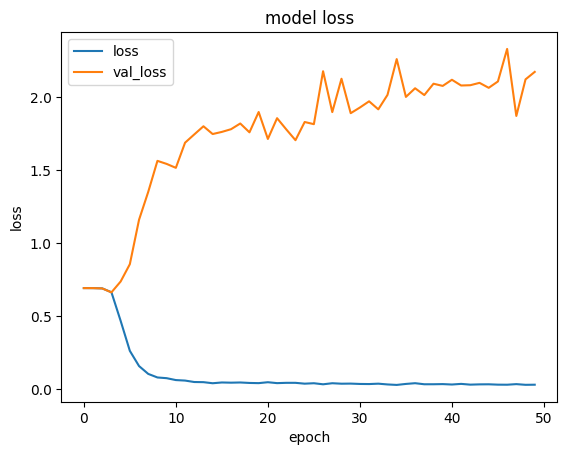

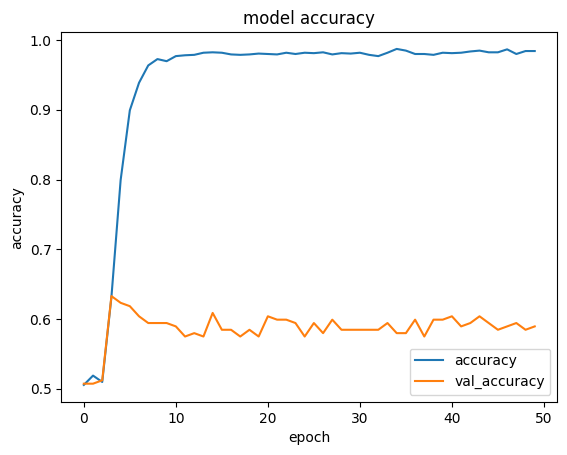

In [ ]:
print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

accuracy = history.history['accuracy']
val_accuracy= history.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [ ]:
#accuracy calculation
loss_and_metrics = model.evaluate(padded,train_labels,batch_size=256)
print("The train accuracy is: "+str(loss_and_metrics[1]))
loss_and_metrics = model.evaluate(testing_padded,test_labels,batch_size=256)
print("The test accuracy is: "+str(loss_and_metrics[1]))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9821 - loss: 0.0321
The train accuracy is: 0.9842233061790466
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6554 - loss: 1.8109
The test accuracy is: 0.6550387740135193


In [ ]:
test_labels_binary = np.argmax(test_labels, axis=1)

In [ ]:
predictions = model.predict(testing_padded)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


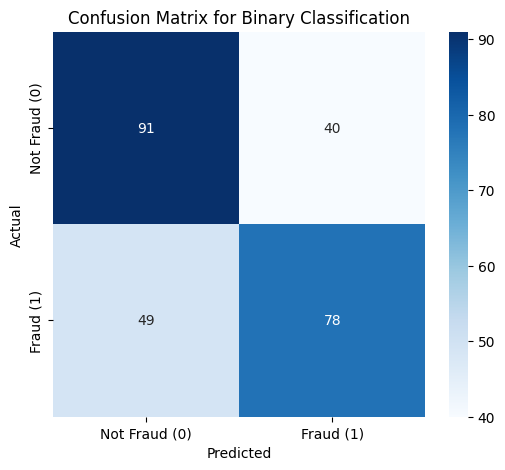

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Step 1: Convert test labels back to binary format (0 or 1)
# If one-hot encoded, we convert it to a binary label (0 or 1)
test_labels_binary = np.argmax(test_labels, axis=1)  # Convert one-hot encoded labels

# Step 2: Make predictions
predictions = model.predict(testing_padded)
predictions = np.argmax(predictions, axis=1)  # Choose the class with the highest probability

# Step 3: Flatten predictions to match shape of the labels (1D)
predictions = predictions.flatten()

# Step 4: Generate the confusion matrix for binary classification
cm = confusion_matrix(test_labels_binary, predictions)

# Step 5: Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud (0)', 'Fraud (1)'], yticklabels=['Not Fraud (0)', 'Fraud (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Binary Classification')
plt.show()